In [1]:
from collections import Counter

import pandas as pd
from sklearn.preprocessing import scale
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('grayscale')
sb.set_style("white")
sb.set_palette("Greys_r")


import bambi as bmb
import arviz as az

import matplotlib.pyplot as plt
#plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = 'Greys_r'

from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Roboto Condensed']
sb.set(font="Roboto Condensed")

In this notebook, we perform the statistical analysis on the results of the large-scale intertext retrieval in a previous notebook. In that notebook, we looked at all combinations of epical texts on the *Cd-rom Middelnederlands*: for each combination of two texts, we combined all the verse groups in them and counted how many of them could be considered "hits" or "intertexts" (i.e. they had a mutual distance that was smaller than the optimal threshold that we established on the manually annotated data). Our primary objective is to assess to which extent the number of intertextual hits between any given text pair is influenced by two (binary) variables:
- whether or not the texts belong to the same subgenre;
- whether or not the texts belong to the same oeuvre.

Additionally, we'll have to take into account the length of the two texts when assessing the hits as an outcome variable.

First, we load our metadata:

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df = meta_df[meta_df['genre'] == 'Epiek']

One difficult issue is that authorship information is not available for many anonymous texts:

In [3]:
meta_df['author'].value_counts(dropna=False)

author
NaN                      164
Lodewijk van Velthem      14
Jacob van Maerlant         9
Philip Utenbroeke          8
Jan van Boendale           6
Augustijnken               2
Heraut Beyeren             1
Jan de Weert               1
Melis Stoke                1
Jan van Heelu              1
Diederic van Assenede      1
Loy Latewaert              1
Hendrik van Veldeke        1
Lambertus Goetman          1
Calfstaf en Noydekin       1
Dirc Potter                1
Willem                     1
Penninc                    1
Pieter Vostaert            1
Segher Diengotgaf          1
Name: count, dtype: int64

Genre information (in the form of a subgenre label) on the other hand is available for all of the texts:

In [4]:
meta_df['subgenre'].value_counts()

subgenre
Karel             54
Didactiek         42
Ridder            38
Historiografie    35
Arthur            17
Heiligenleven     11
Kruisvaart        10
Religie            7
Dier               3
Name: count, dtype: int64

We now load the intertext retrieval data that we created in the previous notebook. Each row represents the combinations of two epic texts, for which we parse the author and subgenre label as a categorical variable. Additionally, we have integers encoding the length of both texts, as well as the number of intertextual matches ("hits") that we registered between them:

In [5]:
df = pd.read_excel('../figures/statistics.xlsx')

df['subgenre'] = (df['subgenre1'] == df['subgenre2']).astype('category')
df['author'] = (df['author1'] == df['author2']).astype('category')
df['hits'] = df['hits'].astype('int')
df['l1'] = df['l1'].astype('int')
df['l2'] = df['l2'].astype('int')

Note the skew in the data: for many pairs, we lack authorship information for at least one work in the pair. Additonally, it is obvious that the texts in most pairs will not share their authorship, nor their genre:

In [6]:
print(df['author'].value_counts())
print(df['subgenre'].value_counts())

author
False    12823
True        57
Name: count, dtype: int64
subgenre
False    10803
True      2077
Name: count, dtype: int64


The number of hits cannot be taken at face value, because of the length differences between works: by simple chance, we should expect more hits between two longer texts than between a short and a long text, so we must normalize this number somehow. One simple way is to divide the number of hits by the product of the two text lengths. This yields fairly small number, so I multiply this with a constant:

In [7]:
df['norm'] = df['hits'] / (df['l1'] * df['l2']) * 1000
df

,t1,t2,l1,l2,hits,genre1,genre2,subgenre1,subgenre2,author1,author2,hit_ratio,subgenre,author,norm
0,Noch meer van wiven,Van der wive wonderlijcheit (lange versie),111,225,149,Epiek,Epiek,Didactiek,Didactiek,NaN,NaN,0.005966,True,False,5.965966
1,Gwidekijn van Sassen,Ongeïdentificeerd (4),199,139,35,Epiek,Epiek,Karel,Karel,NaN,NaN,0.001265,True,False,1.265319
2,Ongeïdentificeerd (4),Roman van Cassant,139,29,5,Epiek,Epiek,Karel,Kruisvaart,NaN,NaN,0.001240,False,False,1.240387
3,Gwidekijn van Sassen,Roman van Cassant,199,29,5,Epiek,Epiek,Karel,Kruisvaart,NaN,NaN,0.000866,False,False,0.866401
4,Ongeïdentificeerd (4),Roman van Antiochië,139,168,16,Epiek,Epiek,Karel,Kruisvaart,NaN,NaN,0.000685,False,False,0.685166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12875,Godevaerts kintshede,Van der wive wonderlijcheit (lange versie),55,225,0,Epiek,Epiek,Kruisvaart,Didactiek,NaN,NaN,0.000000,False,False,0.000000
12876,Godevaerts kintshede,Van der manen zeden,55,301,0,Epiek,Epiek,Kruisvaart,Didactiek,NaN,NaN,0.000000,False,False,0.000000
12877,Godevaerts kintshede,Van den vijf vrouden,55,72,0,Epiek,Epiek,Kruisvaart,Didactiek,NaN,NaN,0.000000,False,False,0.000000
12878,Godevaerts kintshede,Van Saladijn,55,289,0,Epiek,Epiek,Kruisvaart,Kruisvaart,NaN,Hein van Aken,0.000000,True,False,0.000000


First, we have a look at the effect of subgenre, and more specifically how the texts in the various subgenre categories tend to relate to one another in terms of intertexts. We can look at the median number of hits across combinations of subgenres:

In [8]:
intergenre = df.groupby(['subgenre1', 'subgenre2'])['norm'].median().reset_index().rename_axis(None, axis=1)
intergenre.sort_values('norm', ascending=False)

,subgenre1,subgenre2,norm
40,Historiografie,Historiografie,0.035647
41,Historiografie,Karel,0.030003
50,Karel,Karel,0.025784
59,Kruisvaart,Karel,0.021083
58,Kruisvaart,Historiografie,0.019939
...,...,...,...
21,Dier,Heiligenleven,0.002242
55,Kruisvaart,Didactiek,0.002195
15,Didactiek,Kruisvaart,0.001008
33,Heiligenleven,Kruisvaart,0.000000


Note that we also compare texts within one subgenre: this gives us an idea of the intertextual coherence of subgenres. We can visualize this information in a heatmap as follows:

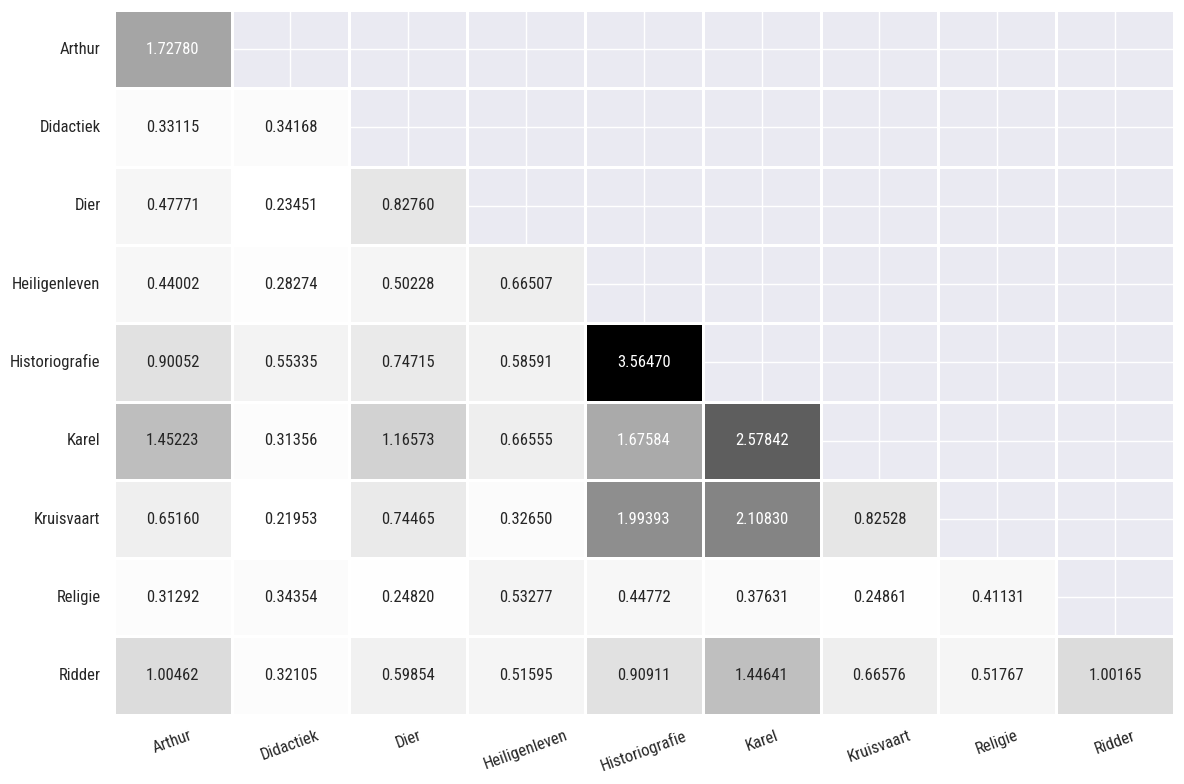

In [9]:
genres = sorted(set(list(intergenre['subgenre1']) + list(intergenre['subgenre2'])))
hits = np.zeros((len(genres), len(genres)))

for _, row in intergenre.iterrows():
    hits[genres.index(row['subgenre1']), genres.index(row['subgenre2'])] = row['norm'] * 100
    hits[genres.index(row['subgenre2']), genres.index(row['subgenre1'])] = row['norm'] * 100

hits[np.triu_indices(hits.shape[1], k=1)] = np.nan
hits = pd.DataFrame(hits, index=genres, columns=genres)
fig, ax = plt.subplots(figsize=(12, 8))

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Roboto Condensed']
sb.set_style("white")
ax = sb.heatmap(hits, annot=True, cmap='Greys', cbar=False,
                annot_kws={'font': 'Roboto Condensed', 'size': 12},
                linewidths=1, linecolor='white', fmt='.5f')
ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), font='Roboto Condensed', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), font='Roboto Condensed', fontsize=12)
for l in plt.gca().lines:
    l.set_alpha(0.3)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(f'../figures/Afb9.jpg', dpi=300);

Finally, we can have a look at the most striking texts pairs that feature an unusually high number of intertexts. When we exclude:
- shorter texts (which are less reliable because they tend to be fragmentary)
- historiographical texts (e.g. chronicles)
- attributed texts

these are the results:

In [10]:
df[(df['l1'] > 2000) & (df['l2'] > 2000) &
   (df['subgenre1'] != 'Historiografie') &
   (df['subgenre2'] != 'Historiografie') &
   (df['subgenre1'] != df['subgenre2']) &
   (df['author1'].isna()) & (df['author2'].isna())
  ].sort_values('norm', ascending=False).head(10)

,t1,t2,l1,l2,hits,genre1,genre2,subgenre1,subgenre2,author1,author2,hit_ratio,subgenre,author,norm
1416,Limborch,Roman der Lorreinen II,21847,9895,6918,Epiek,Epiek,Ridder,Karel,NaN,NaN,0.000032,False,False,0.032002
1607,Ferguut,Renout van Montalbaen,5602,2552,407,Epiek,Epiek,Arthur,Karel,NaN,NaN,0.000028,False,False,0.028469
1714,Limborch,Renout van Montalbaen,21847,2552,1480,Epiek,Epiek,Ridder,Karel,NaN,NaN,0.000027,False,False,0.026545
1794,Renout van Montalbaen,Walewein ende Keye,2552,2809,182,Epiek,Epiek,Karel,Arthur,NaN,NaN,0.000025,False,False,0.025389
1856,Der mannen ende vrouwen heimelijcheit,Roman der Lorreinen II,2328,9895,569,Epiek,Epiek,Didactiek,Karel,NaN,NaN,0.000025,False,False,0.024701
1876,Ferguut,Roman der Lorreinen II,5602,9895,1355,Epiek,Epiek,Arthur,Karel,NaN,NaN,0.000024,False,False,0.024444
1960,Der mannen ende vrouwen heimelijcheit,Ferguut,2328,5602,307,Epiek,Epiek,Didactiek,Arthur,NaN,NaN,0.000024,False,False,0.023540
1980,Moriaen,Renout van Montalbaen,4482,2552,266,Epiek,Epiek,Arthur,Karel,NaN,NaN,0.000023,False,False,0.023256
1989,Perchevael,Renout van Montalbaen,3654,2552,216,Epiek,Epiek,Arthur,Karel,NaN,NaN,0.000023,False,False,0.023164
2035,Renout van Montalbaen,Wrake van Ragisel,2552,2066,120,Epiek,Epiek,Karel,Arthur,NaN,NaN,0.000023,False,False,0.022760


There are several ways to rank the resulting text pairs, but no matter how we look at the data, the combination of the *Limborch* and the *Lorreinen II* is strikingly high. For comparison, we can look at the texts which Heeroma attributed to the same poet:

In [11]:
trg = ['Moriaen', 'Lantsloot van der Haghedochte', 'Karel ende Elegast']
trg_df = df[(df['t1'].isin(trg)) & (df['t2'].isin(trg))]
th = trg_df['norm'].mean()
trg_df.sort_values('norm')

,t1,t2,l1,l2,hits,genre1,genre2,subgenre1,subgenre2,author1,author2,hit_ratio,subgenre,author,norm
1662,Karel ende Elegast,Lantsloot van der Haghedochte,1363,5837,219,Epiek,Epiek,Karel,Arthur,NaN,NaN,0.000028,False,False,0.027527
1339,Karel ende Elegast,Moriaen,1363,4482,204,Epiek,Epiek,Karel,Arthur,NaN,NaN,0.000033,False,False,0.033394
862,Lantsloot van der Haghedochte,Moriaen,5837,4482,1226,Epiek,Epiek,Arthur,Arthur,NaN,NaN,0.000047,True,False,0.046863


### Statistical analysis

While the (potentially shared) authorship of the *Limborch* and *Lorreinen* is interesting "bycatch", there are also issues of more theoretical relevance to be considered. One interesting question is the *relative* strength of (shared) authorship vs (shared) subgenre when it comes to predicting the number of intertexts that we observe between a pair of texts. This relationship, however, is not trivial to study. A first issue is that the length of texts must be considered. Text length, however, is correlated with the attributional status of works in the corpus: simple put, if we think we know the author of texts, these texts tend to be longer.

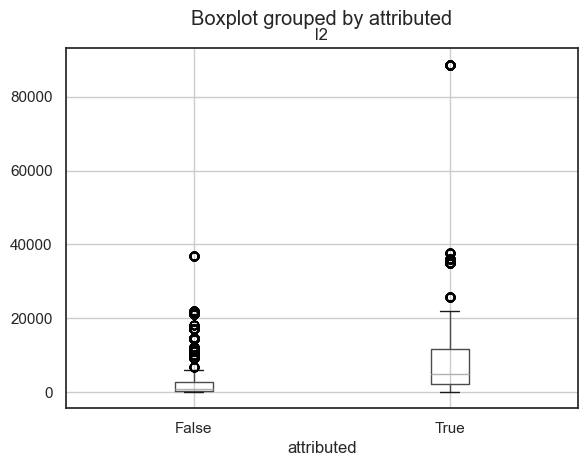

In [12]:
df['attributed'] = ~df['author2'].isna()
df.boxplot('l2', 'attributed');

That makes sense: fragmentary texts tend to lack prologues and epilogues, where authors typically reveal themselves. Additionally, if we want to do a fair analysis of authorship vs subgenre, we should limit ourselves to combinations of texts where we have information available on *both* authorship and subgenre, which means we need to ignore quite a number of text combinations:

In [13]:
df_stats = df.copy()

df_stats = df[df['author1'].notna()]
df_stats = df_stats[df_stats['author2'].notna()]

def compare_na(v1, v2):
    same = (v1 == v2) | (v1.isna() & v2.isna())
    same = same.fillna(False)
    return same

df_stats['author'] = compare_na(df_stats['author1'], df_stats['author2']).astype('category')
df_stats['genre'] = compare_na(df_stats['subgenre1'], df_stats['subgenre2']).astype('category')

print('all text combinations:', len(df))
print('selected text combinations:', len(df_stats))

all text combinations: 12880
selected text combinations: 666


Below, we cross-tabulate the counts to see many texts we end up in each combinations of our two boolean variables:

author  False  True
genre              
False     495    44
True      114    13


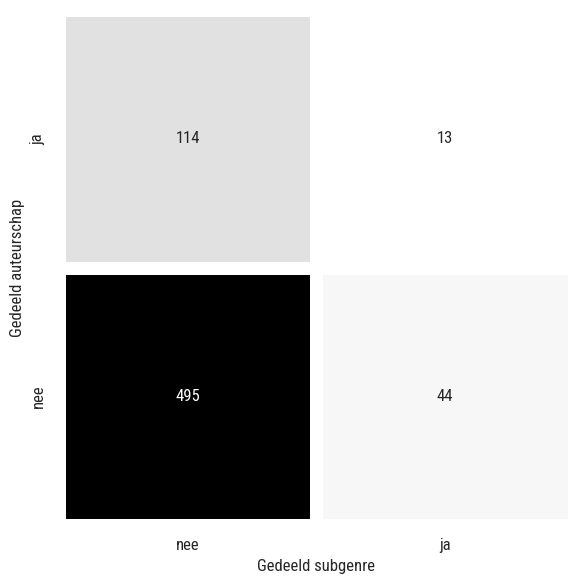

In [14]:
cross_tab = pd.crosstab(df_stats['genre'], df_stats['author'])
print(cross_tab)
cross_tab.index = cross_tab.index.map({True: 'ja', False: 'nee'})
cross_tab.columns = cross_tab.columns.map({True: 'ja', False: 'nee'})
cross_tab = cross_tab.reindex(['ja', 'nee'])

sb.set(font_scale=1)
plt.figure(figsize=(6, 6))
ax = sb.heatmap(cross_tab, 
            annot=True,
            fmt='d',
            cmap='Greys',
            cbar=False,
            annot_kws={'font': 'Roboto Condensed', 'size': 12},
            linewidths=9,
            square=True)

ax.set_xticklabels(ax.get_xticklabels(), font='Roboto Condensed', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), font='Roboto Condensed', fontsize=12)
ax.tick_params(left=False, bottom=False)

plt.xlabel('Gedeeld subgenre', font='Roboto Condensed', fontsize=12)
plt.ylabel('Gedeeld auteurschap', font='Roboto Condensed', fontsize=12)
plt.tight_layout()
plt.savefig(f'../figures/Afb8b.jpg', dpi=300);

The "hits" is a variable with a heavy left-skew: most of the text pairs show a low number of hits (even if we normalize for the length of the texts), and frequently no hits whatsoever were found:

count    666.000000
mean       0.014689
std        0.030425
min        0.000000
25%        0.003436
50%        0.007449
75%        0.014790
max        0.582291
Name: norm, dtype: float64


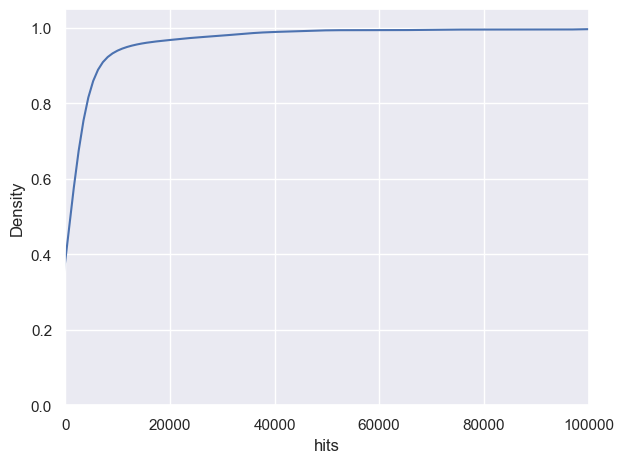

In [15]:
print(df_stats['norm'].describe())
ax = sb.kdeplot(data=df_stats['hits'], cumulative=True)
ax.set_xlim(0, 100000)
plt.tight_layout()

Below, we will model "hits" as a strictly, positive count (integer) variable. Therefore, we'll need to take into account the product of the lengths of the texts in a pair as well. Below, we'll take the square root of this length product and log that (to increase numerical stability).

In [16]:
df_stats['length'] = np.log(np.sqrt(df_stats['l1'] * df_stats['l2']))

After some consideration (and lots of discussion with Benjamin Nagy -- thanks, Ben!), I opted for a negative binomial distribution to model the outcome variable. Other option (such as the Gaussian) moreover did not paint a very different story. Below, I run four Bayesian models, with additive combinations of our predictors:
- `m1`: hits predicted on the basis of length (which we can see as a baseline model);
- `m2`: hits predicted on the basis of length and authorship;
- `m3`: hits predicted on the basis of length and genre;
- `m4`: hits predicted on the basis of length and genre and authorship.

In [17]:
m1 = bmb.Model('hits ~ length', data=df_stats, family='negativebinomial')
fit1 = m1.fit(idata_kwargs=dict(log_likelihood = True))

m2 = bmb.Model('hits ~ author + length', data=df_stats, family='negativebinomial')
fit2 = m2.fit(idata_kwargs=dict(log_likelihood = True))

m3 = bmb.Model('hits ~ genre + length', data=df_stats, family='negativebinomial')
fit3 = m3.fit(idata_kwargs=dict(log_likelihood = True))

m4 = bmb.Model('hits ~ genre + author + length', data=df_stats, family='negativebinomial')
fit4 = m4.fit(idata_kwargs=dict(log_likelihood = True))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, length]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, author, length]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, genre, length]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, genre, author, length]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can now compare the relative performance of these models:

In [18]:
compare_dict = {
    'exp': fit1,
    'exp + author': fit2,
    'exp + genre': fit3,
    'exp + genre + author': fit4,
}

loo_compare = az.compare(compare_dict, ic='loo')
loo_compare

/Users/mikekestemont/miniconda3/envs/mdu/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/mikekestemont/miniconda3/envs/mdu/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/mikekestemont/minic

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
exp + genre + author,0,-4520.105045,14.133992,0.000000,6.470658e-01,74.489296,0.000000,True,log
exp + genre,1,-4522.894942,11.807580,2.789898,1.742800e-01,73.362769,4.459766,True,log
exp + author,2,-4574.567257,16.637219,54.462213,2.502929e-16,81.044422,20.026953,True,log
exp,3,-4579.795476,13.206610,59.690431,1.786542e-01,78.868836,18.451735,True,log


As expected, this is a hard problem, with some highly influential observations. The `r_hat` seem to be fine, however (~1.0):

In [19]:
az.summary(fit4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.941,0.048,0.857,1.034,0.001,0.000,5596.0,3400.0,1.0
Intercept,-13.331,0.363,-14.001,-12.648,0.005,0.004,5184.0,3446.0,1.0
genre[True],1.063,0.108,0.857,1.258,0.001,0.001,5397.0,3617.0,1.0
author[True],0.436,0.147,0.156,0.694,0.002,0.001,6331.0,3307.0,1.0
length,2.218,0.041,2.146,2.302,0.001,0.000,5461.0,3415.0,1.0


If we compare the models' performance (using the "LOO" criterion), we see that the most complex gives the optimal fit (as was probably to be expected), but that their ranges in perdictive power overlap, so that it is hard to prefer one model over the other. If we consider the means, we see that each predictor helps, but that genre is generally more helpful than authorship.

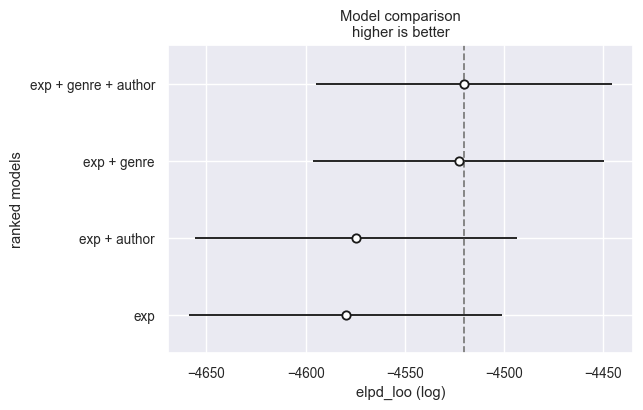

In [20]:
az.plot_compare(loo_compare);

The fourth model is the more interesting one for us, because it allows us to compare the relative contribution of author and genre. The plots below show that the chains have mixed well for the model:

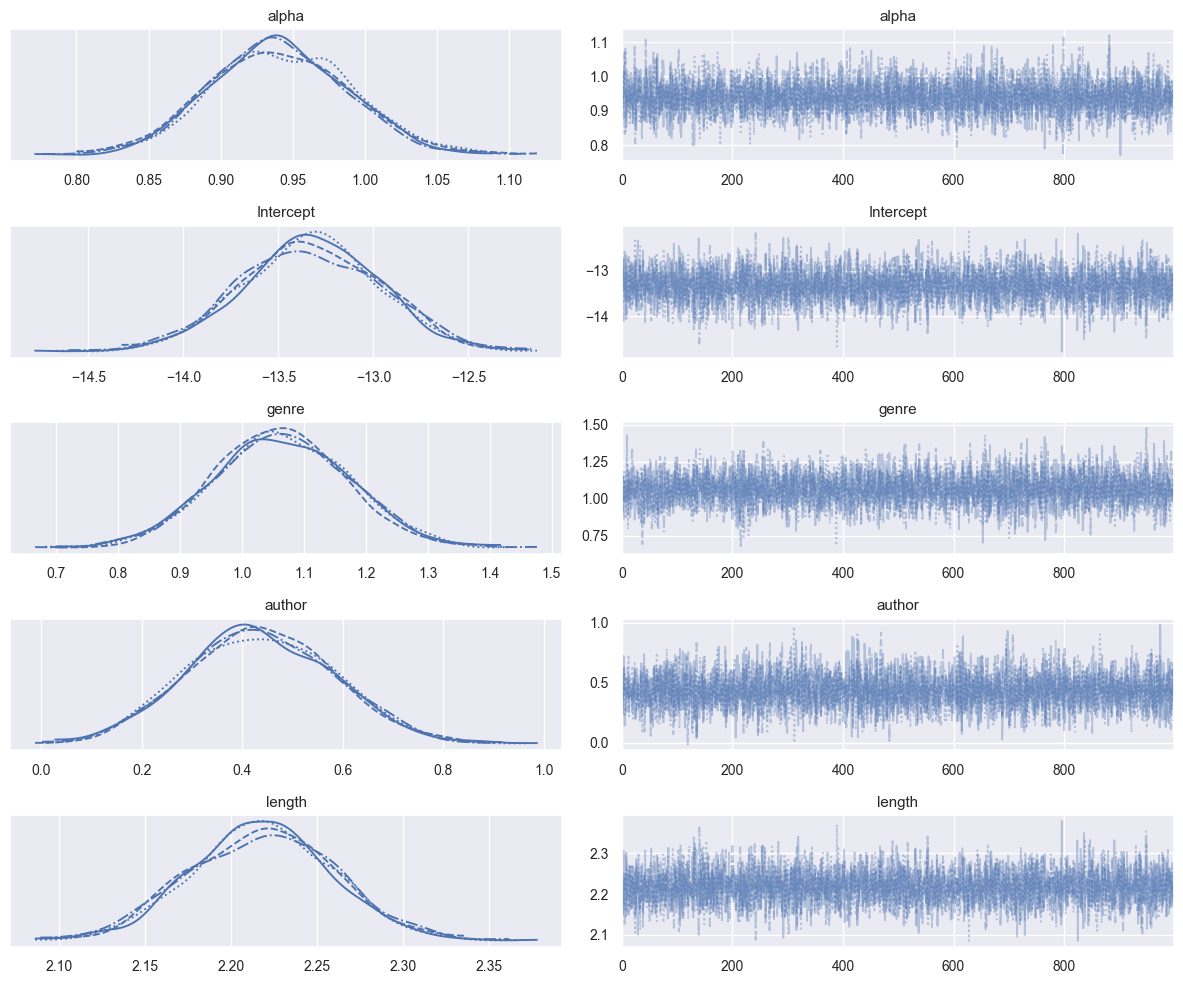

In [21]:
az.plot_trace(fit4)
plt.tight_layout();

If we plot the predictions made by the model, we can observe that it managed to approximate the empirical distribution fairly well, which is reassuring:

/var/folders/6j/pn9nz6b55j3fpdt8gtj50crm0000gn/T/ipykernel_18449/2165123903.py:4: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout();


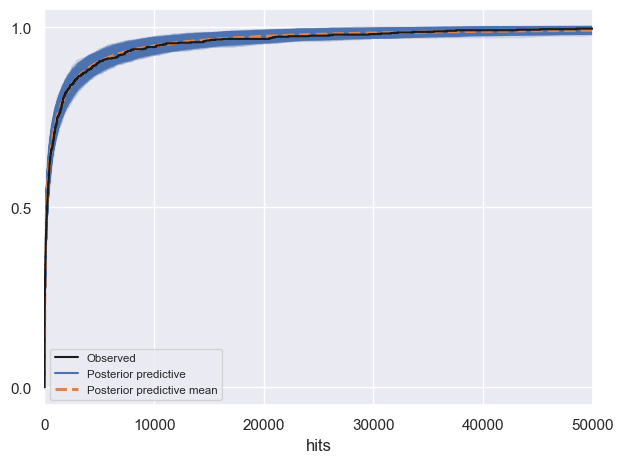

In [22]:
m4.predict(fit4, kind='response')
ax = az.plot_ppc(fit4, kind='cumulative')
ax.set_xlim(0, 50000)
plt.tight_layout();

If we do a forest plot, we see that each of the two predictors contribute meaningfully to the model: the effect of genre, again, is a bit more outspoken than author, but none of the credible intervals intersect with zero:

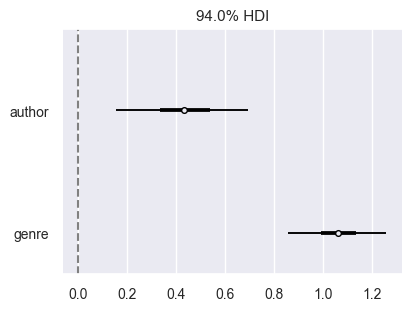

In [23]:
fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
az.plot_forest(fit4, 
               kind="forestplot", hdi_prob=0.94, combined=True, ax=ax,
               var_names=["author", "genre"],
               textsize=10, colors=["black"])
plt.axvline(0, c='grey', ls='--');

Another convincing visualization is the effects plot below. Here, we plot the effect for each combination of the four levels:

In [24]:
def effects_plot(model, results, predictors, sec_labels, x_label=None, xticklabels=None):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
    plot_output = bmb.interpret.plot_predictions(
        model, 
        results, 
        predictors, 
        ax=ax,
        prob=.89
    )

    for i, collection in enumerate(ax.collections):
        collection.set_color('black' if i < 2 else 'gray')
        if isinstance(collection, matplotlib.collections.PathCollection):
            collection.set_sizes([100])

    legend_elements = []

    for i in range(2):
        legend_elements.append(plt.Line2D([0], [0], 
                                        color='black' if i == 0 else 'gray', 
                                        marker='o', 
                                        markersize=10,
                                        linestyle='None'))

    ax.legend(legend_elements, sec_labels, 
            loc='upper left', prop={'family': 'Roboto Condensed', 'size': 12},
            bbox_to_anchor=(0, 1))
    
    
    ax.set_ylabel('Hits', font='Roboto Condensed', fontsize=12)
    if x_label is not None:
        ax.set_xlabel(x_label, font='Roboto Condensed', fontsize=12)

    if xticklabels:
        ax.set_xticklabels(xticklabels, font='Roboto Condensed', fontsize=12)

    ax.set_xticklabels(ax.get_xticklabels(), font='Roboto Condensed', fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), font='Roboto Condensed', fontsize=12)

    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['legend.edgecolor'] = 'white'

    plt.tight_layout()
    fig.subplots_adjust(right=0.85)

    return fig, ax

Default computed for conditional variable: length
Default computed for unspecified variable: author, genre
/var/folders/6j/pn9nz6b55j3fpdt8gtj50crm0000gn/T/ipykernel_18449/1349724235.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), font='Roboto Condensed', fontsize=12)
/var/folders/6j/pn9nz6b55j3fpdt8gtj50crm0000gn/T/ipykernel_18449/1349724235.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), font='Roboto Condensed', fontsize=12)
Default computed for conditional variable: genre, author
Default computed for unspecified variable: length
/var/folders/6j/pn9nz6b55j3fpdt8gtj50crm0000gn/T/ipykernel_18449/1349724235.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixed

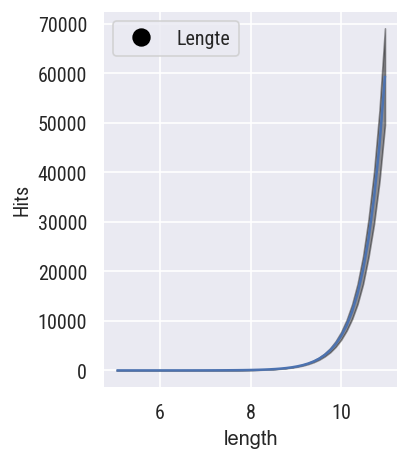

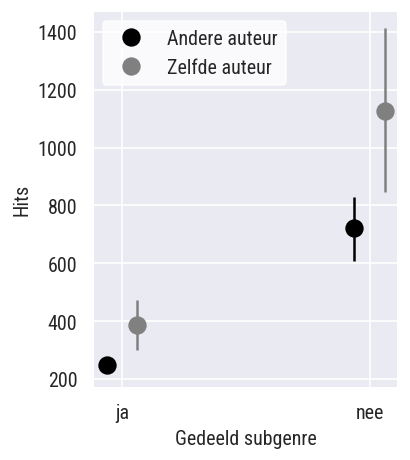

In [25]:
effects_plot(model=m4, results=fit4, predictors = ["length"], sec_labels = ['Lengte'])
effects_plot(model=m4, results=fit4, predictors = ["genre", "author"], sec_labels = ['Andere auteur', 'Zelfde auteur'],
             x_label='Gedeeld subgenre', xticklabels=['ja', 'nee'])
plt.savefig(f'../figures/Afb9b.jpg', dpi=300);

This figure suggests that sharing subgenre indeed boosts the number of intertexts between two texts, but that sharing authorship, on top of that, also ups the number of intertexts.